### 統計學習與深度學習 (Fall, 2024)
### Homework 3

請將IPYNB檔與IPYNB Export之HTML檔上傳至COOL作業區。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。
如無其他規定，所有重要結果應顯示至小數點第四位(四捨五入)。


### 第一題 [Resnet as a Feature Extractor]

(30%) Resnet是一個常用的CNN影像分類的架構。許多深度學習平台，如Pytorch，提供已經在ImageNet資料集上訓練好的模型(i.e., 權重)。這些模型可以直接用來取代傳統的特徵工程。我們在本題與下一期要來嘗試與比較這個方向。

為了方便討論，我們使用Resnet50。當然同樣的作法可以用在其他類似的模型上。

Resnet50的模型架構大致上是

```
ResNet(
  (conv1):

   .... [omitted] ...

  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
)

```
我們忽略前面的所有層，只專注在最後一層。是一個線性層。輸入是2048維，輸出是1000維。因此如果要把訓練好的Resnet50當成是Feature Extractor，我們可以直些使用模型的最後輸出(尚未進入Softmax)的1000維向量，或是使用前一層的輸出，也就是2048維向量。本題將嘗試使用最後的1000維向量來代表一張圖片。下一題將使用前一層的輸出的2048維向量代表圖片。

請以Pytorch提供的預訓練模型(`torchvision.models.resnet50(weights="IMAGENET1K_V2")`)作為起點往下發展。

為了控制不同的分類器可能會帶來的影響。我們選用Logistic Regression作為最後圖片分類的分類器。也就是說每張在訓練集的圖片都通過同一個Pre-trained Resnet50，轉換成一個1000維的向量。然後訓練一個Logistic Regression做圖片分類。接下來把每一張測試資料通過同一個Pre-trained Resnet50轉換成1000維的向量。使用訓練好的Logistic Regression預測分類，並計算分類效能。

這裡的圖片分類任務我們選用Food101資料集。這個資料集有101類食物的照片。任務是看照片分類食物。

為了節省大家的資料整備時間，我們提供`food101_hwds.tgz`檔案。請下載並存放置工作目錄，並執行`tar zxvf food101_hwds.tgz ./`。你會在工作目錄看到一個food101目錄，下有一個food-101目錄，接下來是`images  license_agreement.txt  meta  README.txt`等檔案。

如果你的資料檔已經正確下載，就可以連上Data Loader:


In [4]:
import torch
import torchvision
from torchvision import models, transforms, datasets

imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]
        
valid_tfms = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(imagenet_stats[0], imagenet_stats[1])])     

batch_size = 196
trainset = torchvision.datasets.Food101(root='./food101', split="train",
                                        download=False, transform=valid_tfms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=6)

validset = torchvision.datasets.Food101(root='./food101', split="test",
                                       download=False, transform=valid_tfms)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                         shuffle=False, num_workers=6)

assert trainset.classes==validset.classes
classes = trainset.classes
classe2idx = trainset.class_to_idx
num_classes = len(classes)

print("Number of classes =", num_classes)

Number of classes = 101


這裡有101個分類。列出前幾個給大家參考:

In [5]:
print(trainset.classes[0:10])

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


為了給大家更具體的想法，下面是一些訓練集的照片與分類:

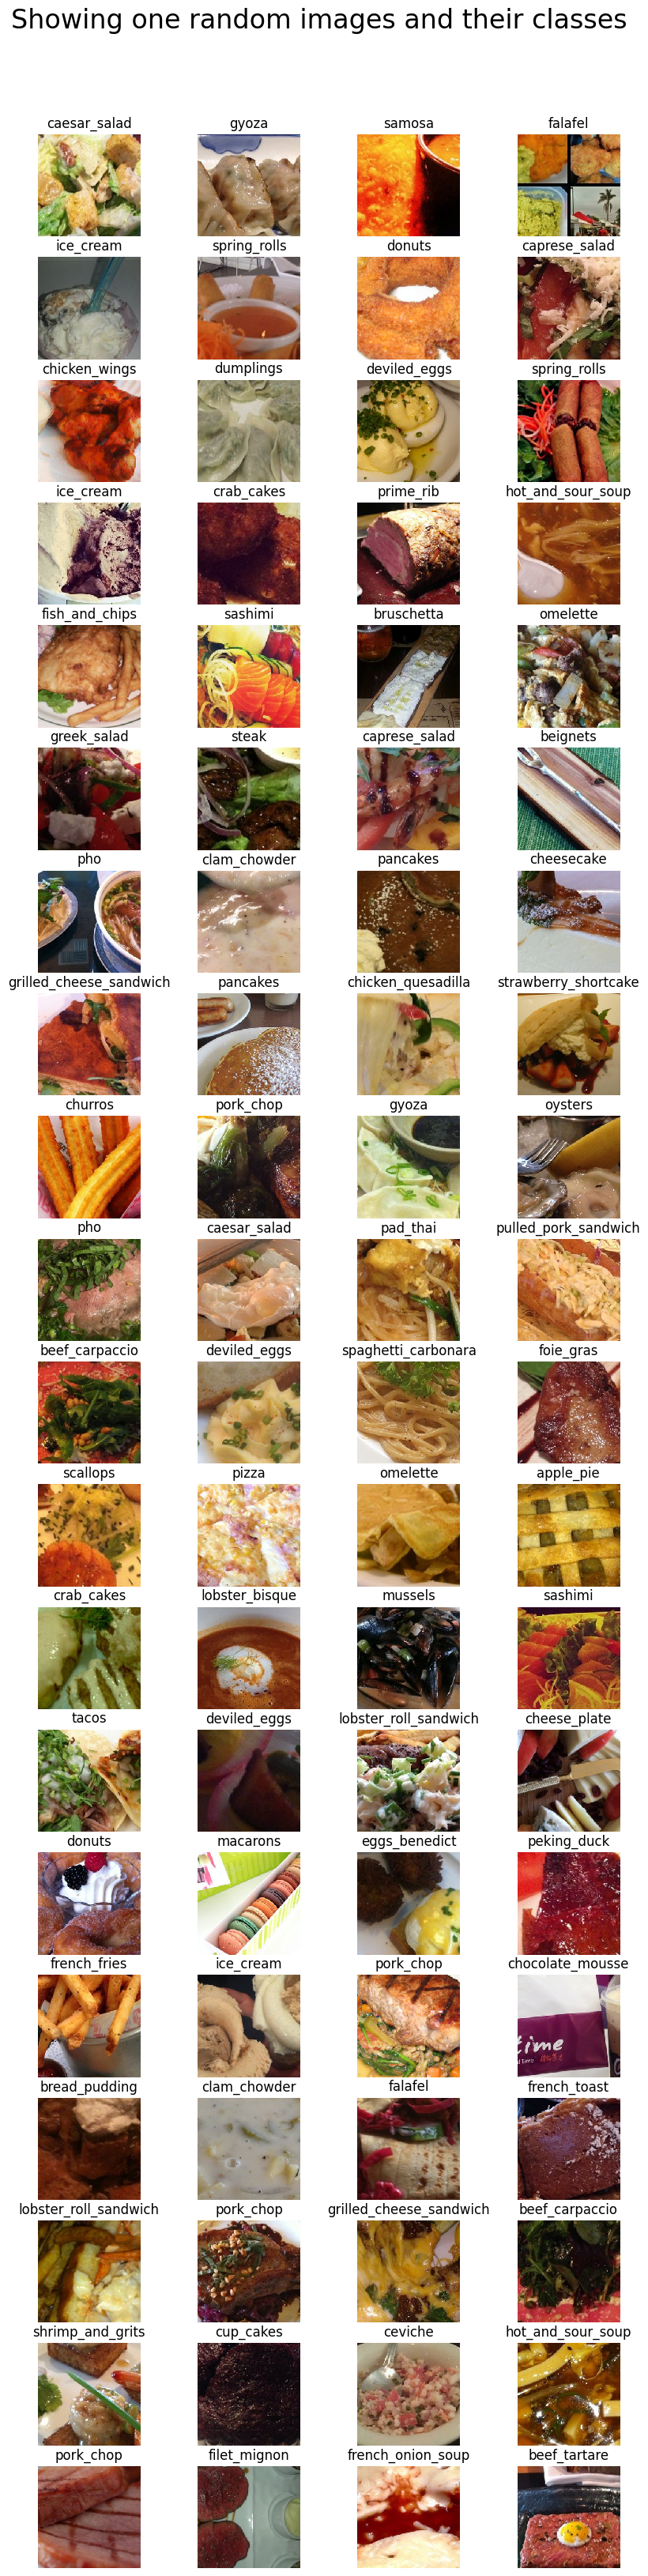

In [6]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,40))
fig.suptitle(f"Showing one random images and their classes", y=0.92, fontsize=24)
columns = 4
rows = 20
imgenet_mean = imagenet_stats[0]
imgenet_std = imagenet_stats[1] 

targetset = trainset
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    
    img_xy = np.random.randint(len(targetset));
    np_img = targetset[img_xy][0].numpy()
    img = np.transpose(np_img, (1,2,0))
    img = img * imgenet_std + imgenet_mean
    
    plt.title(classes[targetset[img_xy][1]])
    plt.axis('off')
    img = np.clip(img, 0, 1)
    plt.imshow(img, interpolation='nearest')

plt.show()

注意:
1. 由於訓練集較大，請隨機在訓練集選取20000張照片訓練Logistic Regression。
2. 請不要調整測試集(Validation Set)
3. 本題主要的分類效能指標為Accuracy與Macro-average F1

----

### 第二題 [Resnet as a Feature Extractor, Part 2]

(20%) 呈上題，使用最後fc輸入的2048維作為特徵。訓練Logistic Regression，並計算分類績效。注意事項與前一題一樣。比較這兩種作法的結果。你覺得應該使用2048維或1000為作為特徵向量?

------



### 第三題 [Resnet Finetuning]

(50%) 接下來我們來嘗試一般的Fine-tuning作法。這個作法是以Pre-trained Resnet50做為起點，將最後一層(fc)換成適合這個分類任務的維度，也就是2048 --> 101的線性層，然後進行模型的Fine-tuning (i.e., training)。

這裡通常有兩種作法，一是在Back Propogation時調整所有的權重，二是只調整最後的fc層。請嘗試並比較這兩者的差別。

注意事項:
* 影像前處理在訓練階段與測試階段不同。訓練階段需要有RandomResizedCrop()與RandomHorizontalFlip()。測試階段則只需CenterCrop()。所有階段都需標準化。
* 訓練時請使用Early Stopping。Patient ＝ 5 epochs。最多訓練100 epochs
* 請使用全部訓練集與測試集。
* 本題主要的分類效能指標為Accuracy與Macro-average F1
* 請提供training loss, validation loss, validation accuracy, validation macro f1在訓練期間的線圖。
* 為了簡化問題。我們以訓練期間最佳的validation performance作為模型的一般性預測力指標。


------
